In [1]:
import pylab as py
import numpy as np
import random as rn
import time
pi = np.pi

In [2]:
def samples_mean(dat,bins):
    """
    This program computes the average <x>m i.e.
    the average of x without the block "m", for each
    m = 1,...,M
    dat --> Array with the data
    bins --> Jackknife blocks
    """
    bins = int(bins)
    Smean = np.zeros(bins)
    prom = 0
    dat_bin = int(len(dat)/bins) 
    for i in range(bins):
        for k in range(bins):
            for j in range((k*dat_bin),k*dat_bin + dat_bin):
                if k != i:
                    prom += dat[j]
        prom = prom/(len(dat)-dat_bin)
        Smean[i] = prom
        prom = 0
    return Smean

def Jerr(dat,bins):
    """
    dat --> Array with the data
    bins --> Jackknife blocks
    """
    err = 0
    sm = samples_mean(dat,bins) 
    normal_mean = np.mean(dat)
    for m in range(bins):
        err += (sm[m] - normal_mean)**2
    err = np.sqrt(err*(bins-1)/bins)
    return err

In [12]:
def AccRatio(mu,beta,L,Masha,BondsX,BondsY,CreateBond):
    if mu == 0:
        nb = BondsX[Masha[0] % L, Masha[1] % L] #Number of bonds in the site Masha in the direction +x
    elif mu == 1:
        nb = BondsX[Masha[0] % L, (Masha[1]-1) % L] #Number of bonds in the site Masha in the direction -x
    elif mu == 2:
        nb = BondsY[(Masha[0]-1) % L, Masha[1] % L] #Number of bonds in the site Masha in the direction +y
    elif mu == 3:
        nb = BondsY[Masha[0] % L, Masha[1] % L] #Number of bonds in the site Masha in the direction -y
        
    if CreateBond == True:
        R = beta/(nb + 1)            
    else:
        R = nb / beta          
    return R
            
def WA_sweep(L,beta,BondsX,BondsY,Masha):
    CreateBond = False 
    #We choose whether to create or delete a bond. 0 --> Forms bond, 1 --> deletes bond
    if rn.randint(0,1) == 0:
        CreateBond = True       
    mu = rn.randint(0, 3) #0 --> +x direction, 1 --> -x direction, 2 --> +y direction, 3 --> -y direction
    R = AccRatio(mu,beta,L,Masha,BondsX,BondsY,CreateBond)
    r = rn.random() #random number between zero and one
    if CreateBond == True:
        nb = 1
    else:
        nb = -1     
    if r < R:
        if mu == 0: 
            BondsX[Masha[0] % L, Masha[1] % L] += nb        
            Masha[1] =  (Masha[1]+1) % L #Move masha one site to the right
        elif mu == 1: 
            BondsX[Masha[0] % L, (Masha[1]-1) % L] += nb
            Masha[1] =  (Masha[1]-1) % L #move masha one site to the left
        elif mu == 2: 
            BondsY[(Masha[0]-1) % L, Masha[1] % L] += nb       
            Masha[0] =  (Masha[0]-1) % L #move masha one site up
        elif mu == 3: 
            BondsY[Masha[0] % L, Masha[1] % L] += nb 
            Masha[0] =  (Masha[0]+1) % L #move masha one site down
    return Masha, BondsX, BondsY

def WA_IsingModel(beta,L,Ntherm,Nmeas,Nsteps):
    Ira = [rn.randint(0, L-1), rn.randint(0,L-1)] #randint(a,b) generates a random number r\in[a,b] (closed interbval)
    Masha = [Ira[0],Ira[1]]
    BondsX = np.zeros((L,L))
    BondsY = np.zeros((L,L))
    Z = 0.0
    G = np.zeros(L**2)
    Chi, NB2_NB, NB = [], [], []    
    for i in range(Ntherm):
        if Masha == Ira:  
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]]         
        Masha, BondsX, BondsY = WA_sweep(L,beta,BondsX,BondsY,Masha)
    Count = 0
    while Count < Nmeas:
        SiteIra = Ira[1] + Ira[0]*L
        SiteMasha = Masha[1] + Masha[0]*L
        G[abs(SiteIra-SiteMasha)] += 1
        if Masha == Ira:
            Z += 1
            Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
            Masha = [Ira[0],Ira[1]] 
            Nb = np.sum(BondsX) + np.sum(BondsY)
            NB.append(Nb)
            NB2_NB.append(Nb**2-Nb)
            Chi.append(np.sum(G)/Z)
            Count += 1
        Masha, BondsX, BondsY = WA_sweep(L,beta,BondsX,BondsY,Masha)
        for j in range(Nsteps):
            SiteIra = Ira[1] + Ira[0]*L
            SiteMasha = Masha[1] + Masha[0]*L
            G[abs(SiteIra-SiteMasha)] += 1
            if Masha == Ira:
                Z += 1
                Ira = [rn.randint(0, L-1), rn.randint(0,L-1)]
                Masha = [Ira[0],Ira[1]] 
            Masha, BondsX, BondsY = WA_sweep(L,beta,BondsX,BondsY,Masha)
    Chi = np.array(Chi)
    NB2_NB = np.array(NB2_NB)
    NB = np.array(NB)
    
    Cv = np.mean(NB2_NB) - np.mean(NB)**2
    dCv = Jerr(NB2_NB,20) + 2 * np.mean(NB) * Jerr(NB,2)
    dChi = Jerr(Chi,20)
    return np.mean(Chi)*beta, dChi*beta, Cv, dCv

In [100]:
Nmeas = 1000
Ntherm = 10000
Nsteps = 100
L = 24
Chi, dChi, Cv, dCv = [], [], [], []
beta = np.linspace(0.3,0.6,20)
for i in range(len(beta)):
    chi, dchi, cv, dcv = WA_IsingModel(beta[i],L,Ntherm,Nmeas,Nsteps)
    Chi.append(chi)
    dChi.append(dchi)
    Cv.append(cv)
    dCv.append(dcv)
    print('beta',beta[i])
    print('chi',chi,'+-',dchi)
    print('cv',cv,'+-',dcv)
    print('------------------------')
Chi = np.array(Chi)
dChi = np.array(dChi)
Cv = np.array(Cv)
dCv = np.array(dCv)

beta 0.3
chi 2.194330499284432 +- 0.015268453505433816
cv 186.31556399999863 +- 1835.9286030683668
------------------------
beta 0.3157894736842105
chi 2.8360401520796095 +- 0.01978940314607212
cv 141.59671600000365 +- 970.028673603621
------------------------
beta 0.33157894736842103
chi 3.711171220607848 +- 0.03324158011635607
cv 273.02590000000055 +- 866.2809434170412
------------------------
beta 0.34736842105263155
chi 4.9083819538126425 +- 0.08132413007871103
cv 232.76953599999615 +- 1499.711619767107
------------------------
beta 0.3631578947368421
chi 7.891903232970642 +- 0.03833254711366558
cv 279.76628399999754 +- 1550.1475566220352
------------------------
beta 0.3789473684210526
chi 11.856397132547073 +- 0.0635173864326189
cv 417.52647600000637 +- 1295.720461309286
------------------------
beta 0.39473684210526316
chi 19.324929599878097 +- 0.2605551578108378
cv 482.09309999999823 +- 869.6266470486813
------------------------
beta 0.4105263157894737
chi 35.956641857292595 +-

In [ ]:
%timeit WA_IsingModel(0.3,10,1000,100,10)

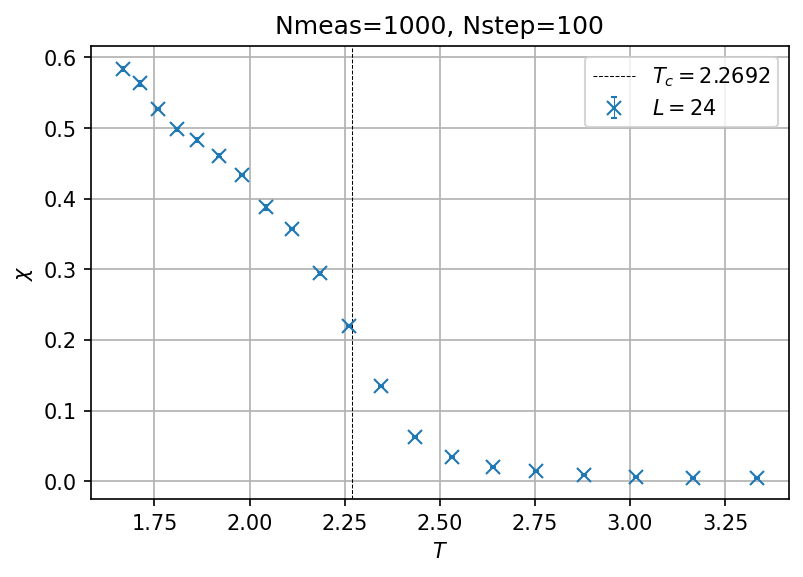

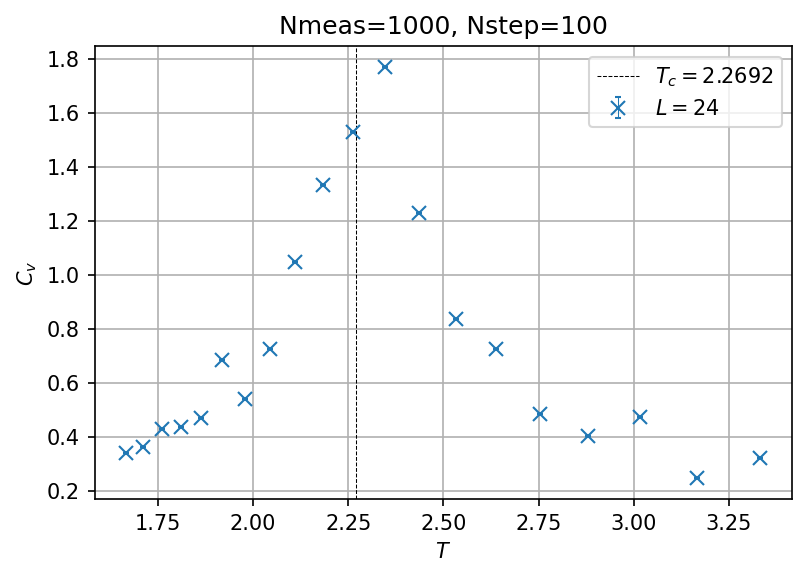

In [101]:
fig = py.figure(dpi=150)
py.errorbar(1/beta,Chi/L**2,yerr=dChi/L**2,fmt='x',markersize='7',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.axvline(x=2/np.log(1+np.sqrt(2)), color='k',linestyle='--',linewidth=0.5,label=r'$T_c=$2.2692')
py.xlabel(r'$T$')
py.ylabel(r'$\chi$')
py.legend()
py.grid()
py.show()
fig.savefig('Chi_L{0}_Nmeas{1}.pdf'.format(L,Nmeas))

fig = py.figure(dpi=150)
py.errorbar(1/beta,Cv/L**2,yerr=[0]*len(Cv),fmt='x',markersize='7',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nsteps))
py.axvline(x=2/np.log(1+np.sqrt(2)), color='k',linestyle='--', linewidth=0.5,label=r'$T_c=$2.2692')
py.xlabel(r'$T$')
py.ylabel(r'$C_v$')
py.legend()
py.grid()
py.show()
fig.savefig('Cv_L{0}_Nmeas{1}.pdf'.format(L,Nmeas))

# Debug

In [76]:
def TotalBonds(BondsX,BondsY,L):
    Bonds = np.zeros((L,L))
    for i in range(L):
        for j in range(L):
            Bonds[i,j] = BondsX[i,j] + BondsY[i,j] + BondsX[i,(j-1)%L] + BondsY[(i-1)%L,j]
    return Bonds

# Version 2

In [7]:
def VectFromSite(Coords,L):
    return (Coords[1] + L*Coords[0])
    
def XFinder(N,L):
    i = 0
    while i < L**2:
        if N < i*L:
            #returns row 
            return (i-1)
        else:
            i += 1
            
def CoordFinder(N,L):
    #Function that finds the coordinates of a site 
    return [XFinder(N,L), N%L]

def AccRatio(mu,beta,L,Masha,Bonds,CreateBond):
    if mu == 0:
        nb = Bonds[Masha,0] #Number of bonds in the site Masha in the direction +x
    elif mu == 1:
        Coords = CoordFinder(Masha,L)
        Coords[1] = (Coords[1] - 1) % L #move to the left
        Masha = VectFromSite(Coords,L)
        nb = Bonds[Masha,0] #Number of bonds in the site Masha in the direction -x
    elif mu == 2:
        Coords = CoordFinder(Masha,L)
        Coords[0] = (Coords[0] - 1) % L #move up
        Masha = VectFromSite(Coords,L)
        nb = Bonds[Masha,1]
    elif mu == 3:
        nb = Bonds[Masha,1] #Number of bonds in the site Masha in the direction -y
    if CreateBond == True:
        R = beta/(nb + 1)            
    else:
        R = nb / beta          
    return R

def Sweep(L,beta,Masha,Bonds):
    mu = rn.randint(0, 3) #0 --> +x direction, 1 --> -x direction, 2 --> y direction, 3 --> -y direction 
    CreateBond = False 
    if rn.randint(0,1) == 0:
        CreateBond = True     
        
    if CreateBond == True:
        nb = 1
    else: 
        nb = -1        
        
    R = AccRatio(mu,beta,L,Masha,Bonds,CreateBond)
    r = rn.random()    
    if r<R:
        if mu == 0:
            Bonds[Masha,0] += nb
            Coords = CoordFinder(Masha,L)
            Coords[1] = (Coords[1] + 1) % L #move to the right
            Masha = VectFromSite(Coords,L)
        elif mu == 1:
            Coords = CoordFinder(Masha,L)
            Coords[1] = (Coords[1] - 1) % L #move to the left
            Masha = VectFromSite(Coords,L)
            Bonds[Masha,0] += nb
        if mu == 2:
            Coords = CoordFinder(Masha,L)
            Coords[0] = (Coords[0] - 1) % L #move up
            Masha = VectFromSite(Coords,L)
            Bonds[Masha,1] += nb
        if mu == 3:
            Bonds[Masha,1] += nb
            Coords = CoordFinder(Masha,L)
            Coords[0] = (Coords[0] + 1) % L #move down
            Masha = VectFromSite(Coords,L)
    return Masha, Bonds

def WA(beta,L,Ntherm,Nmeas,Nsteps):
    Ira = rn.randint(0,L**2-1)
    Masha = Ira
    Bonds = np.zeros((L**2,2))
    G = np.zeros(L**2)
    Chi = []
    for i in range(Ntherm):
        if Ira == Masha:
            Ira = rn.randint(0,L**2-1)
            Masha = Ira   
        Masha, Bonds = Sweep(L,beta,Masha,Bonds)
    count = 0
    while count < Nmeas:
        G[abs(Masha-Ira)] += 1
        if Ira == Masha:
            Chi.append(sum(G)/G[0])
            Ira = rn.randint(0,L**2-1)
            Masha = Ira   
            count += 1
        Masha, Bonds = Sweep(L,beta,Masha,Bonds)
        for i in range(Nsteps):
            G[abs(Masha-Ira)] += 1
            if Ira == Masha:
                Ira = rn.randint(0,L**2-1)
                Masha = Ira   
            Masha, Bonds = Sweep(L,beta,Masha,Bonds)
    Chi = np.array(Chi)
    dchi = Jerr(Chi,20)
    return np.mean(Chi)*beta, dchi*beta

In [10]:
%timeit WA(0.3,10,1000,100,10)

48.3 ms ± 1.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [107]:
beta = np.linspace(0.3,0.6,20)
L = 10
Ntherm = 10000
Nmeas = 1000
Nstep = 100
Chi, dChi = [], []
for i in range(len(beta)):
    chi, dchi = WA(L,beta[i],Ntherm,Nmeas,Nstep)
    print('i',i,'beta',beta[i])
    print('chi',chi,'dchi',dchi)
    Chi.append(chi)
    dChi.append(dchi)
Chi = np.array(Chi)
dChi = np.array(dChi)

i 0 beta 0.3
chi 2.278265066888954 dchi 0.03306881557603701
i 1 beta 0.3157894736842105
chi 2.8433942019867886 dchi 0.024783608067106826
i 2 beta 0.33157894736842103
chi 3.640241693655481 dchi 0.01566400937298314
i 3 beta 0.34736842105263155
chi 4.908066768057757 dchi 0.0170309274214605
i 4 beta 0.3631578947368421
chi 6.720472224870285 dchi 0.06562271788546097
i 5 beta 0.3789473684210526
chi 9.159764529361917 dchi 0.038740536623648965
i 6 beta 0.39473684210526316
chi 12.847619662603911 dchi 0.0630948179080025
i 7 beta 0.4105263157894737
chi 17.169087211353308 dchi 0.10270893256442434
i 8 beta 0.4263157894736842
chi 21.912570071359973 dchi 0.13635014359096423
i 9 beta 0.4421052631578947
chi 27.27524603414055 dchi 0.10571274306866786
i 10 beta 0.45789473684210524
chi 32.47982471590919 dchi 0.11434932360905643
i 11 beta 0.4736842105263158
chi 36.32482226374063 dchi 0.06921829614947363
i 12 beta 0.4894736842105263
chi 39.00006675063275 dchi 0.15802708738335342
i 13 beta 0.5052631578947369


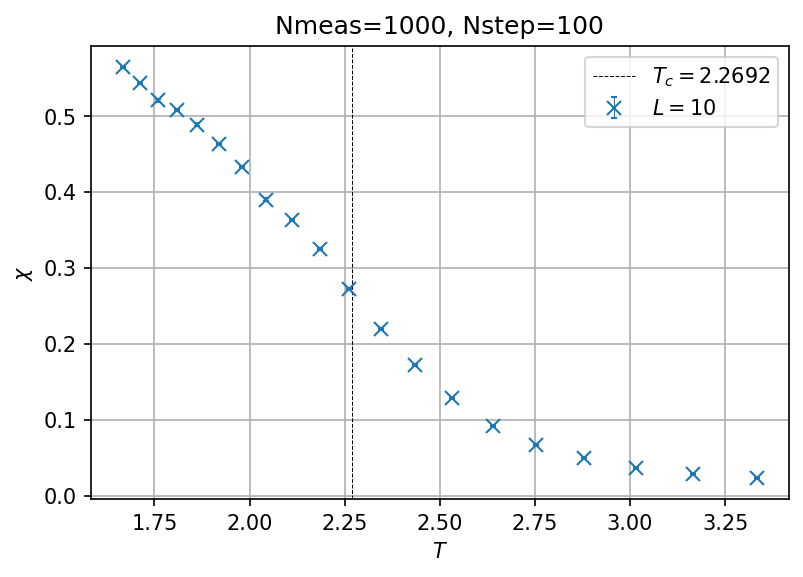

In [109]:
fig = py.figure(dpi=150)
py.errorbar(1/beta,Chi/L**2,yerr=dChi/L**2,fmt='x',markersize='7',\
elinewidth=0.5,solid_capstyle='projecting', capsize=1.5,label=r'$L=${0}'.format(L))
py.title('Nmeas={0}, Nstep={1}'.format(Nmeas,Nstep))
py.axvline(x=2/np.log(1+np.sqrt(2)), color='k',linestyle='--',linewidth=0.5,label=r'$T_c=$2.2692')
py.xlabel(r'$T$')
py.ylabel(r'$\chi$')
py.legend()
py.grid()
fig.savefig('Chi_L{0}_Nmeas{1}.pdf'.format(L,Nmeas))